In [130]:
import os
import sys
import sqlite3

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

# Ensure the parent directory is in the path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

import settings

In [2]:
with sqlite3.connect(settings.DATABASE_PATH) as conn:
    df = pd.read_sql(
        f"""
            SELECT * FROM Matches
        """,
        conn,
    )

In [3]:
df = df.dropna(subset=["score"]).copy()
df["home_score"] = df["score"].str.split(":").str[0].astype(int)
df["away_score"] = df["score"].str.split(":").str[1].astype(int)
df["home_win"] = (df["home_score"] > df["away_score"]).astype(int)
df["away_win"] = (df["home_score"] < df["away_score"]).astype(int)
df["tie"] = (df["home_score"] == df["away_score"]).astype(int)
df["difference_score"] = abs(df["home_score"] - df["away_score"])


In [4]:
def adjust_date(row):
    """
    Adjust the date by adding the correct century based on the season.
    If the date"s year is less than the season"s end year, use the start year,
    otherwise use the end year of the season.

    :param row: A row from the DataFrame containing "date" and "season".
    :return: Adjusted date string in the format DD/MM/YYYY.
    """
    start_year = int(row["season"].split("-")[0])
    end_year = int(row["season"].split("-")[1])
    date_year = int(row["date"].split("/")[-1])

    if date_year == start_year % 100:
        return row["date"][:-2] + str(start_year)
    else:
        return row["date"][:-2] + str(end_year)


df["date"] = df.apply(adjust_date, axis=1)
df = df.dropna(subset=["date"])
df["date"] = pd.to_datetime(df["date"], format="%m/%d/%Y")

In [5]:
df = df.dropna(subset=["score"])
df["season"] = df["season"].str.split("-").str[0].astype(int)

conditions = [
    (df['home_win'] == 1),
    (df['tie'] == 1),
    (df['away_win'] == 1)
]

choices = [1, 0, -1]

df['result'] = np.select(conditions, choices, default=None)


In [6]:
def calculate_team_results(df: pd.DataFrame) -> pd.DataFrame:
    """
    Creates a DataFrame from a historic table of results to a final standings of each season and division.
    It is ordered by points per season. In case two teams have same number of points, is ordered by GD (de-
    scending), and then by GF (also descending).

    :param df: DataFrame containing match data for all teams.
    :return: DataFrame with results for each team and season.
    """

    df_results = (
        pd.concat(
            [
                df.groupby(["division", "season", "home_team"])
                .agg(
                    GF=("home_score", "sum"),
                    GA=("away_score", "sum"),
                    W=("home_win", "sum"),
                    L=("away_win", "sum"),
                    T=("tie", "sum"),
                )
                .reset_index()
                .rename(columns={"home_team": "team"}),
                df.groupby(["division", "season", "away_team"])
                .agg(
                    GF=("away_score", "sum"),
                    GA=("home_score", "sum"),
                    W=("away_win", "sum"),
                    L=("home_win", "sum"),
                    T=("tie", "sum"),
                )
                .reset_index()
                .rename(columns={"away_team": "team"}),
            ]
        )
        .groupby(["division", "season", "team"])
        .sum()
        .reset_index()
    )

    df_results["GD"] = df_results["GF"] - df_results["GA"]
    df_results["points"] = df_results["W"] * 3 + df_results["T"]

    df_results = df_results.sort_values(
        by=["division", "season", "points", "GD", "GF"],
        ascending=[True, False, False, False, False],
    ).reset_index(drop=True)

    df_results["rank"] = (
        df_results.groupby(["season", "division"])["points"]
        .rank("first", ascending=False)
        .astype(int)
    )

    df_results = df_results[
        [
            "season",
            "division",
            "rank",
            "team",
            "GF",
            "GA",
            "GD",
            "W",
            "L",
            "T",
            "points",
        ]
    ]
    return df_results

In [9]:
def team_confrontations(df, team1, team2):
    df_confrontations = df.loc[
        ((df["home_team"] == team1) | (df["away_team"] == team1))
        & ((df["home_team"] == team2) | (df["away_team"] == team2))
    ]

    return df_confrontations

def won_games(df, team: str):
    """
    Returns those winning games for a given team
    """
    home_wins = (df["home_team"] == team) & (df["home_win"] == 1)
    away_wins = (df["away_team"] == team) & (df["away_win"] == 1)
    return df[home_wins | away_wins]


def lost_games(df, team: str):
    """
    Returns those winning games for a given team
    """
    home_lost = (df["home_team"] == team) & (df["home_win"] == 0)
    away_lost = (df["away_team"] == team) & (df["away_win"] == 0)
    tie_games = (df["home_team"] == team) & (df["tie"] == 1) | (df["away_team"] == team) & (df["tie"] == 1)

    return df[(home_lost | away_lost) & ~tie_games]


In [10]:
# def difference_points(df_calculate, df_results, season):
#     """
#     This function calculates the difference in points between two teams.
#     """
#     return df_calculate.apply(
#         lambda row: df_results.loc[
#             (df_results["team"] == row["home_team"]) & (df_results["season"] == season), "points"
#         ].values[0]
#         - df_results.loc[
#             (df_results["team"] == row["away_team"]) & (df_results["season"] == season), "points"
#         ].values[0],
#         axis=1,
#     )

# def inform_relatives_points(df, df_calculate, season):
#     df_season = df.loc[df["season"] == season].copy()
#     df_results = calculate_team_results(df_season)
#     df_calculate["points_relative"] = difference_points(df_calculate, df_results, season)
#     df_calculate["points_relative_index"] = df_calculate["points_relative"] * (df_calculate["matchday"]**2 / (df_calculate["matchday"]**2 + 38) ) # As the season goes on, the importance of the relative points increases
#     return df_calculate

In [11]:
# def win_lost_index(df, season, team1, team2):
#     """
#     This function returns a victory and lose punctuation between 2 teams.
#     It is given by 1 / ((currentseason - season) + 1)^2
#     This function has a maximum in currentseason and it deacreses as season increase
#     Giving more importance to recent matches.

#     It is symmetric for both teams, so win_team1 = lost_team2.
#     """
#     df_conf = team_confrontations(df, team1, team2)
    
    
#     df_won = won_games(df_conf, team1).copy()
#     df_won.loc[:, "win_punct"] = 1 / ((season - df_won["season"].astype(int))**2 + 1)
#     win_punct = df_won["win_punct"].sum()

#     df_lost = lost_games(df_conf, team1).copy()
#     df_lost.loc[:, "lost_punct"] = 1 / ((season - df_lost["season"].astype(int))**2 + 1)
#     lost_punct = df_lost["lost_punct"].sum()

#     return win_punct, lost_punct


# def inform_win_lost_index(df, df_calculate, season):
#     df_necesary = df.loc[df["season"] >= (season - 20)].copy()
#     df_calculate[["win_punct", "lost_punct"]] = df_calculate.apply(
#         lambda row: win_lost_index(df_necesary,season, row["home_team"], row["away_team"]),
#         axis=1, result_type="expand"
#     )
#     return df_calculate


In [12]:
def win_lost_index(row, df_conf_dict):
    """
    Calculates win and loss punctuation between two teams for the row's season,
    using a precomputed dictionary of relevant confrontations for each season.

    This function returns a victory and lose punctuation between 2 teams.
    It is given by 1 / ((currentseason - season)^2 + 1)
    This function has a maximum in currentseason and it deacreses as season increase
    Giving more importance to recent matches.
    It is symmetric for both teams, so win_team1 = lost_team2.

    :param row: A row from the DataFrame containing "season", "home_team" and "away_team".
    :param df_conf_dict: A dictionary containing relevant confrontations for each season.
    :return: A tuple with the win and loss punctuation for the row's season.
    """
    season = row["season"]
    team1 = row["home_team"]
    team2 = row["away_team"]
    
    df_conf = df_conf_dict.get((team1, team2), pd.DataFrame())
    
    df_won = won_games(df_conf, team1)
    if not df_won.empty:
        df_won["win_punct"] = 1 / ((season - df_won["season"].astype(int)) ** 2 + 1)
        win_punct = df_won["win_punct"].sum()
    else:
        win_punct = 0
    
    df_lost = lost_games(df_conf, team1)
    if not df_lost.empty:
        df_lost["lost_punct"] = 1 / ((season - df_lost["season"].astype(int)) ** 2 + 1)
        lost_punct = df_lost["lost_punct"].sum()
    else:
        lost_punct = 0
    
    return win_punct, lost_punct

def inform_win_lost_index(df, df_calculate):
    """
    Adds win and loss punctuation to the DataFrame for each row's season.

    :param df: DataFrame containing match data for all teams.
    :param df_calculate: DataFrame containing the matches to calculate the win and loss punctuation.
    :return: DataFrame with the win and loss punctuation for each row's season.
    """
    max_season = df_calculate["season"].max()
    df_recent = df[df["season"] >= (max_season - 20)].copy()
    
    teams = df_calculate[["home_team", "away_team"]].drop_duplicates()
    df_conf_dict = {
        (team1, team2): team_confrontations(df_recent, team1, team2)
        for team1, team2 in zip(teams["home_team"], teams["away_team"])
    }
    
    df_calculate[["win_punct", "lost_punct"]] = df_calculate.apply(
        lambda row: win_lost_index(row, df_conf_dict),
        axis=1, result_type="expand"
    )
    
    return df_calculate


In [13]:
def difference_points(row, df_results_dict):
    """
    Calculates the difference in points between the home and away teams
    for a given season, using a dictionary of results for each season.

    :param row: A row from the DataFrame containing "home_team", "away_team", and "season".
    :param df_results_dict: Dictionary of results for each season.
    """
    season = row["season"]
    home_team_points = df_results_dict[season].loc[df_results_dict[season]["team"] == row["home_team"], "points"].values[0]
    away_team_points = df_results_dict[season].loc[df_results_dict[season]["team"] == row["away_team"], "points"].values[0]
    return home_team_points - away_team_points

def inform_relatives_points(df, df_calculate):
    """
    Calculates the relative points for each match in the DataFrame,
    using a dictionary of results for each season.

    Uses the equation:
    relative_points = difference_points * (matchday^2 / (matchday^2 + 38))
    This function makes more relevant the relative points as the season goes on.

    :param df: DataFrame with match data.
    :param df_calculate: DataFrame with calculated features.
    :return: DataFrame with relative points.
    """

    seasons = df["season"].unique()
    df_results_dict = {season: calculate_team_results(df[df["season"] == season]) for season in seasons}
    
    df_calculate["points_relative"] = df_calculate.apply(
        lambda row: difference_points(row, df_results_dict), axis=1
    )
    
    df_calculate["points_relative_index"] = (
        df_calculate["points_relative"] * (df_calculate["matchday"] ** 2 / (df_calculate["matchday"] ** 2 + 38))
    )
    
    return df_calculate



In [ ]:
def calculate_results(df):
    """
    Precalculates results for all matches.
    """
    home_results = df[['matchday', 'season', 'home_team', 'home_win', 'tie']].copy()
    home_results['team'] = home_results['home_team']
    home_results['Result'] = np.where(
        home_results['tie'] == 1, 'T',
        np.where(home_results['home_win'] == 1, 'W', 'L')
    )
    
    away_results = df[['matchday', 'season', 'away_team', 'away_win', 'tie']].copy()
    away_results['team'] = away_results['away_team']
    away_results['Result'] = np.where(
        away_results['tie'] == 1, 'T',
        np.where(away_results['away_win'] == 1, 'W', 'L')
    )
    
    all_results = pd.concat([
        home_results[['matchday', 'season', 'team', 'Result']],
        away_results[['matchday', 'season', 'team', 'Result']]
    ]).sort_values(['team', 'season', 'matchday'], ascending=[True, True, False])
    
    return all_results

def get_last_5_results(all_results, matchday, team, season):
    """
    Gets all available results up to 5 for a team in a season.
    """
    mask = (all_results['team'] == team) & \
           (all_results['season'] == season) & \
           (all_results['matchday'] < matchday)
    
    results = all_results[mask]['Result'].head(5).tolist()
    return results, len(results)

def convert_results_to_points(results_tuple):
    """
    Converts results to points with correction factor for fewer than 5 matches.
    """
    results, num_matches = results_tuple
    if num_matches == 0:
        return 0
    
    points_map = {'W': 3, 'L': 0, 'T': 1}
    total_points = sum(points_map[result] for result in results)
    
    correction_factor = 5 / num_matches
    corrected_points = total_points * correction_factor
    
    return round(corrected_points, 2) 

def last5index(df, df_predict):
    """
    Calculates the last 5 matches index for all teams with correction for fewer matches.
    """
    # df_calculate has the last 5 matches results so takes the same season as df_predict and the matchday is less than the matchday of the match to predict
    df_calculate = df.loc[(df['season'] == df_predict['season'].max()) & (df['matchday'] < df_predict['matchday'].max()) & (df['matchday'] >=df_predict['matchday'].max() - 5)].copy()
    
    all_results = calculate_results(df_calculate)

    df_predict['last5_home'] = df_predict.apply(
        lambda row: get_last_5_results(all_results, row['matchday'], row['home_team'], row['season']), 
        axis=1
    )
    
    df_predict['last5_away'] = df_predict.apply(
        lambda row: get_last_5_results(all_results,  row['matchday'], row['away_team'], row['season']), 
        axis=1
    )
    df_predict['last5_home'] = df_predict['last5_home'].apply(convert_results_to_points)
    df_predict['last5_away'] = df_predict['last5_away'].apply(convert_results_to_points)
    
    return df_predict



## Pretreatment

In [101]:
# Data that will be used for training
train_season = 2015
depth = 20 # Number of seasons to consider for training

df_train = df.loc[(df["season"] > (train_season - depth)) & (df["season"] <= train_season)].copy()

df_train = inform_relatives_points(df, df_train)
df_train = inform_win_lost_index(df, df_train)
df_train = last5index(df, df_train)


## Train

In [ ]:
features = ["win_punct", "lost_punct", "points_relative_index", "last5_home", "last5_away"]
target = "result"

x_train = df_train[features]
y_train = df_train[target]

le = LabelEncoder()
y_train = le.fit_transform(y_train)  

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=40)

clf = GradientBoostingClassifier()
clf.fit(x_train, y_train)

y_val_pred = clf.predict(x_val)
validation_accuracy = (y_val_pred == y_val).mean()
print(f"Validation Accuracy: {validation_accuracy:.2%}")

#Save the model
import joblib
joblib.dump(clf, "../models/model2-11-20s.pkl")


Validation Accuracy: 70.37%


['../models/model2-11-20s.pkl']

## Performance

=== Model Performance Analysis ===



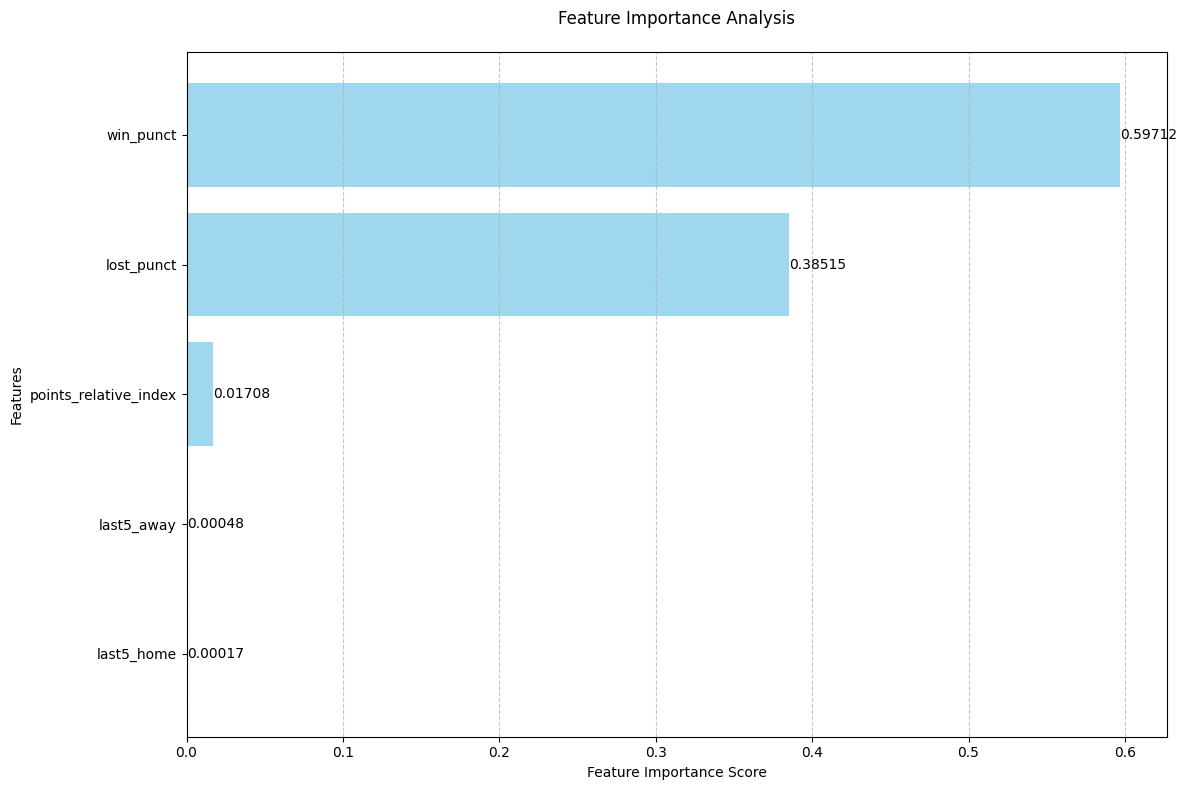

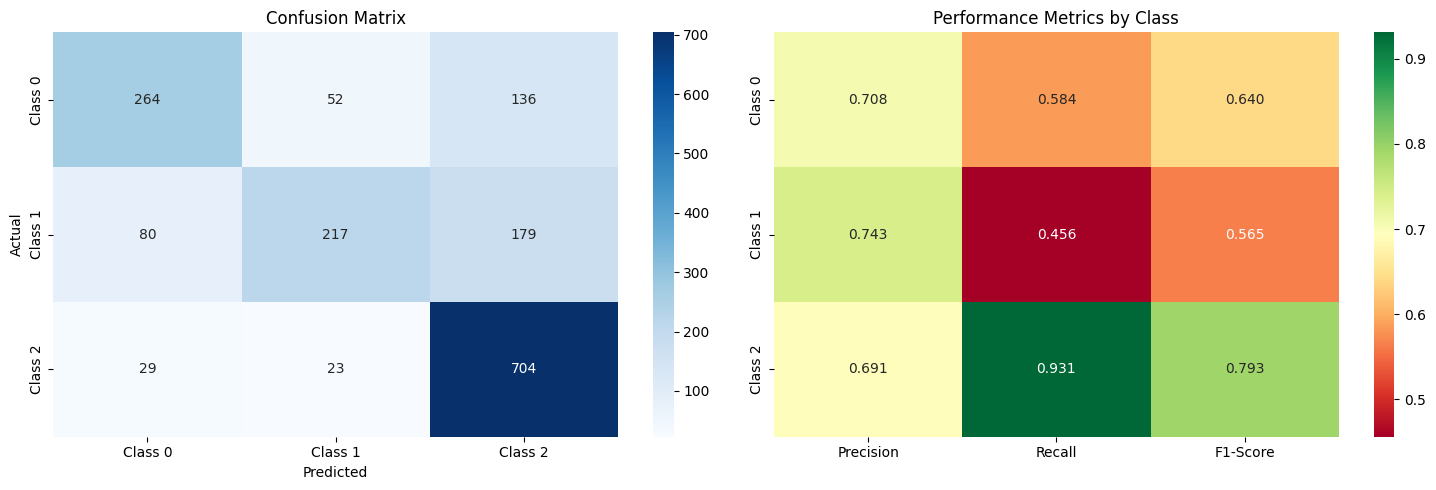


Detailed Classification Report:
              precision    recall  f1-score   support

     Class 0       0.71      0.58      0.64       452
     Class 1       0.74      0.46      0.57       476
     Class 2       0.69      0.93      0.79       756

    accuracy                           0.70      1684
   macro avg       0.71      0.66      0.67      1684
weighted avg       0.71      0.70      0.69      1684


Overall Model Accuracy: 0.704


In [131]:

def plot_feature_importance(feature_importance, figsize=(12, 8)):
    """
    Creates an enhanced feature importance visualization
    """
    plt.figure(figsize=figsize)
    
    bars = plt.barh(feature_importance["feature"], 
                   feature_importance["importance"], 
                   color='skyblue',
                   alpha=0.8)
    
    for bar in bars:
        width = bar.get_width()
        plt.text(width, 
                bar.get_y() + bar.get_height()/2,
                f'{width:.5f}',
                ha='left',
                va='center',
                fontsize=10)
    
    plt.xlabel("Feature Importance Score")
    plt.ylabel("Features")
    plt.title("Feature Importance Analysis", pad=20)
    
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.gca().invert_yaxis()
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix_analysis(y_true, y_pred, clf, figsize=(15, 5)):
    """
    Creates a comprehensive confusion matrix analysis with metrics
    """
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    classes = clf.classes_
    class_names = [f'Class {c}' if isinstance(c, (int, np.integer)) else str(c) for c in classes]
    
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    sns.heatmap(conf_matrix, 
                annot=True, 
                fmt='d', 
                cmap='Blues', 
                xticklabels=class_names,
                yticklabels=class_names,
                ax=ax1)
    ax1.set_xlabel("Predicted")
    ax1.set_ylabel("Actual")
    ax1.set_title("Confusion Matrix")
    
    metrics_data = pd.DataFrame({
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }, index=class_names)
    
    sns.heatmap(metrics_data, 
                annot=True, 
                fmt='.3f', 
                cmap='RdYlGn',
                ax=ax2)
    ax2.set_title("Performance Metrics by Class")
    
    plt.tight_layout()
    plt.show()
    
    print("\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

def analyze_model_performance(feature_importance, y_true, y_pred, clf):
    """
    Performs comprehensive model analysis
    """
    print("=== Model Performance Analysis ===\n")
    
    plot_feature_importance(feature_importance)
    plot_confusion_matrix_analysis(y_true, y_pred, clf)
    
    accuracy = (y_true == y_pred).mean()
    print(f"\nOverall Model Accuracy: {accuracy:.3f}")

feature_importance = pd.DataFrame(
    {
        "feature": features,
        "importance": clf.feature_importances_,
    }
)
feature_importance = feature_importance.sort_values("importance", ascending=False)
analyze_model_performance(feature_importance, y_val, y_val_pred, clf)

## Example of usage

In [95]:
model_path = "../models/model2-11.pkl"

if os.path.exists(model_path):
    clf = joblib.load(model_path)
else:
    print(f"Model file not found at {model_path}, uncomment the previous cell to train the model")

In [99]:
season_to_predict = 1999
matchday_to_predict = 10
df_predict = df.loc[(df["season"] == season_to_predict) & (df["matchday"] == matchday_to_predict)].copy()
df_predict
df_predict = inform_relatives_points(df, df_predict)
df_predict = inform_win_lost_index(df, df_predict)
df_predict = last5index(df, df_predict)
x_predict = df_predict[features]

y_predict = clf.predict(x_predict)
y_predict = le.inverse_transform(y_predict)
df_predict["prediction"] = y_predict
df_predict["correct"] = df_predict["result"] == df_predict["prediction"]
print(df_predict["correct"].sum() / df_predict.shape[0] * 100)

df_predict

61.904761904761905


,season,division,matchday,date,time,home_team,away_team,score,home_score,away_score,...,difference_score,result,points_relative,points_relative_index,win_punct,lost_punct,last5_home,last5_away,prediction,correct
17548,1999,1,10,1999-10-30,None,Málaga CF,Valencia,1:1,1,1,...,0,0,-16,-11.594203,0.520652,1.267742,2.0,10.0,0,True
17549,1999,1,10,1999-10-30,None,Dep. La Coruña,Barcelona,2:1,2,1,...,1,1,5,3.623188,3.263145,2.445831,7.0,11.0,1,True
17550,1999,1,10,1999-10-30,None,Real Madrid,Atlético Madrid,1:3,1,3,...,2,-1,24,17.391304,1.459227,1.563371,4.0,9.0,-1,True
17551,1999,1,10,1999-10-31,None,Racing,RCD Mallorca,1:1,1,1,...,0,0,-5,-3.623188,2.220146,1.127855,7.0,7.0,1,False
17552,1999,1,10,1999-10-31,None,Espanyol,Real Zaragoza,1:1,1,1,...,0,0,-16,-11.594203,2.504049,0.528577,7.0,12.0,1,False
17553,1999,1,10,1999-10-31,None,Alavés,Celta de Vigo,1:0,1,0,...,1,1,8,5.797101,1.754193,0.418807,2.0,12.0,1,True
17554,1999,1,10,1999-10-31,None,Real Betis,Real Sociedad,1:0,1,0,...,1,1,-5,-3.623188,2.247380,1.906698,9.0,2.0,1,True
17555,1999,1,10,1999-10-31,None,Real Valladolid,Rayo Vallecano,1:2,1,2,...,1,-1,1,0.724638,0.718803,3.250964,5.0,7.0,-1,True
17556,1999,1,10,1999-10-31,None,CD Numancia,Sevilla FC,2:0,2,0,...,2,1,17,12.318841,1.538462,1.762852,5.0,5.0,1,True
17557,1999,1,10,1999-10-31,None,Athletic,Real Oviedo,1:1,1,1,...,0,0,5,3.623188,1.087050,2.215752,6.0,8.0,1,False


In [18]:
df_predict
#calculate how many results are results_predicted == result


,season,division,matchday,date,time,home_team,away_team,score,home_score,away_score,...,away_win,tie,difference_score,result,points_relative,points_relative_index,win_punct,lost_punct,prediction,correct
47958,2021,1,3,2021-08-27,8:00 PM,RCD Mallorca,Espanyol,1:0,1,0,...,0,0,1,1,5,0.957447,1.259278,0.755466,0,False
47959,2021,1,3,2021-08-27,10:15 PM,Valencia,Alavés,3:0,3,0,...,0,0,3,1,7,1.340426,1.469147,0.138462,0,False
47960,2021,1,3,2021-08-28,5:00 PM,Celta de Vigo,Athletic,0:1,0,1,...,1,0,1,-1,-4,-0.765957,0.768505,1.390781,0,False
47961,2021,1,3,2021-08-28,7:30 PM,Real Sociedad,Levante,1:0,1,0,...,0,0,1,1,4,0.765957,1.723054,0.813787,1,True
47962,2021,1,3,2021-08-28,7:30 PM,Elche CF,Sevilla FC,1:1,1,1,...,0,1,0,0,-5,-0.957447,0.500000,0.555385,0,True
47963,2021,1,3,2021-08-28,10:00 PM,Real Betis,Real Madrid,0:1,0,1,...,1,0,1,-1,-5,-0.957447,0.378589,1.859984,0,False
47964,2021,1,3,2021-08-29,5:00 PM,Barcelona,Getafe,2:1,2,1,...,0,0,1,1,7,1.340426,2.337726,0.514977,1,True
47965,2021,1,3,2021-08-29,7:30 PM,Cádiz CF,CA Osasuna,2:3,2,3,...,1,0,1,-1,-3,-0.574468,0.000000,2.225429,-1,True
47966,2021,1,3,2021-08-29,7:30 PM,Rayo Vallecano,Granada CF,4:0,4,0,...,0,0,4,1,1,0.191489,1.232056,0.027580,1,True
47967,2021,1,3,2021-08-29,10:00 PM,Atlético Madrid,Villarreal,2:2,2,2,...,0,1,0,0,4,0.765957,0.887403,0.221126,0,True
